# Gann Hilo en MACD strategy

Verbetering(?) van de originele [Hilo, ST & MACD strategie](./Gann HiLo%2C Supertrend en MACD strategy.ipynb).

## Idee

* Type: Swingtrade (what's new...)
* Timeframe: 1d (past het beste bij mijn tradingstijl)
* 8 Coins in backtest.conf, alle 8 worden getrade als het kan


## Oorspronkelijke indicatoren in gebruik

* Gann Hilo: High period 13, Low period 21
* MACD: Fast 12, Slow 26, Smooth 9
* Supertrend: Multiplier 4.5, Days 10

## Aanpassingen van deze indicatoren

* Gann Hilo: High period **21**, Low period 21
* [WEG] MACD: Fast 12, Slow 26, Smooth 9
* [WEG] Supertrend: Multiplier 4.5, Days 10

## Mogelijke nieuwe indicatoren

Ter voorkoming van onnodig instappen, op het juiste moment uitstappen (en tijdig take profit nemen). Ook Drawdown moet zoveel mogelijk geminimaliseerd worden.

* PSAR (Parabolic SAR): 
* CMO (Chande momentum Oscillator): 
* RSI

## Tradingplan oud

### Entry

1. Close price > Gann HiLo
2. MACD > MACD signal
3. Supertrend = 1 (buy)

### Exit

1. Als < Gann HiLo dan EXIT TRADE! (crossdown signaal)
2. OF MACD < MACD Signal

TakeProfit:

* Trendriding, er wordt tussentijds geen take profit gedaan.

Trailing stoploss:

* Als 50% is gehaald en 20% terug dan take profit (verder finetunen)

Vaste stoploss:

* 100% van de freqtrade vaste stoploss (mag niet getriggerd worden)
* Een trade werkt niet als de prijs onder de HiLo waarde sluit (lower low). Dit is daarom de stoploss in het systeem.

## Aanpassingen aan de oorspronkelijke strategie

* Hilo: High = 21, Low = 21
* RSI 14

### Entry

1. Als Close > Hilo
2. Als RSI14 > 55 (Filter: afkomstig van de klassieke Gekko strategie)

### Exit

1. Als Close < Hilo

## Backtest resultaten


``freqtrade backtesting --config user_data/configs/backtest_conf.json --strategy-path /opt/freqtrade/user_data/strategies/ --strategy-list superhilo_strat_prod superhilo kcx_strat_prod supertrend_strat_prod --timeframe 1d``

Entry:

```
               (dataframe["close"] > dataframe["hilo"])
                & (dataframe["rsi"] > 55)
```

Exit:

```
                (dataframe["close"] < dataframe["hilo"])
```

```
2017-08-17 00:00:00 -> 2021-09-08 00:00:00 | Max open trades : 8
=============================================================================== STRATEGY SUMMARY ==============================================================================
|              Strategy |   Buys |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |      Avg Duration |   Win  Draw  Loss  Win% |              Drawdown |
|-----------------------+--------+----------------+----------------+-------------------+----------------+-------------------+-------------------------+-----------------------|
|  superhilo_strat_prod |    189 |          33.01 |        6239.54 |         12491.559 |        1249.16 |  26 days, 2:17:00 |    88     0   101  46.6 | 444.841 USDT  222.20% |
|             superhilo |    253 |          26.96 |        6819.89 |         13653.410 |        1365.34 | 23 days, 21:04:00 |   110     0   143  43.5 | 621.982 USDT  310.68% |
|        kcx_strat_prod |    437 |           8.73 |        3814.63 |          7636.893 |         763.69 |  11 days, 4:43:00 |   181     0   256  41.4 | 564.157 USDT  281.80% |
| supertrend_strat_prod |    120 |          79.24 |        9509.27 |         19037.558 |        1903.76 |  57 days, 9:12:00 |    61     0    59  50.8 | 655.748 USDT  327.55% |
===============================================================================================================================================================================
```

## Backtest resultaten

```
    def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        dataframe.loc[
            (
               (dataframe["close"] > dataframe["hilo"])
                & (dataframe["rsi"] > 55) 
            ),
            "buy",
        ] = 1

        return dataframe

    def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        dataframe.loc[
            (
                (dataframe["close"] < dataframe["hilo"])
                | (dataframe["macd"] < dataframe["macdsignal"])
            ),
            "sell",
        ] = 1
```

```

2017-08-17 00:00:00 -> 2021-09-08 00:00:00 | Max open trades : 8
=============================================================================== STRATEGY SUMMARY ==============================================================================
|              Strategy |   Buys |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |      Avg Duration |   Win  Draw  Loss  Win% |              Drawdown |
|-----------------------+--------+----------------+----------------+-------------------+----------------+-------------------+-------------------------+-----------------------|
|  superhilo_strat_prod |    189 |          33.01 |        6239.54 |         12491.559 |        1249.16 |  26 days, 2:17:00 |    88     0   101  46.6 | 444.841 USDT  222.20% |
|             superhilo |    328 |          17.15 |        5625.32 |         11261.890 |        1126.19 | 15 days, 20:47:00 |   144     0   184  43.9 | 426.114 USDT  212.84% |
|        kcx_strat_prod |    437 |           8.73 |        3814.63 |          7636.893 |         763.69 |  11 days, 4:43:00 |   181     0   256  41.4 | 564.157 USDT  281.80% |
| supertrend_strat_prod |    120 |          79.24 |        9509.27 |         19037.558 |        1903.76 |  57 days, 9:12:00 |    61     0    59  50.8 | 655.748 USDT  327.55% |
===============================================================================================================================================================================

```

Vooralsnog blijkt de oorspronkelijke SuperHilo beter te preseteren.

In het geval van lagere tijdsframes wordt er steeds slechter gepresteerd. 

**Moraal van het verhaal is dat meer traden (op lagere tijdsframes) geen significant voordeel opleveren behalve dat je er meer stress van ondervindt!.**

In [14]:
# Importeer de benodigde bibliotheken
import pandas as pd
import pandas_ta as pta
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Load data
df = pd.read_json("./data/BTC_USDT-1d.json")
df.columns=['date','open','high','low','close','volume']
df['date']=(pd.to_datetime(df['date'],unit='ms'))
df.tail(5)

,date,open,high,low,close,volume
1480,2021-09-05,49917.54,51900.00,49450.00,51756.88,40544.835873
1481,2021-09-06,51756.88,52780.00,50969.33,52663.90,49249.667081
1482,2021-09-07,52666.20,52920.00,42843.05,46863.73,123048.802719
1483,2021-09-08,46868.57,47340.99,44412.02,46048.31,65069.315200
1484,2021-09-09,46048.31,47399.97,45513.08,46395.14,50651.660020


## HILO

In [18]:
highl = 21
lowl = 21
df['hilo'] = pta.hilo(high=df['high'], low=df['low'], close=df['close'], high_length=highl, low_length=lowl, mamode=None, offset=None)[f"HILO_{highl}_{lowl}"]
df['buy1'] = (df['close'] > df['hilo'])
df[['date','close','hilo','buy1']].tail(10)

,date,close,hilo,buy1
1475,2021-08-31,47100.89,45985.366190,True
1476,2021-09-01,48810.52,46335.623333,True
1477,2021-09-02,49246.64,46564.864286,True
1478,2021-09-03,49999.14,46760.076190,True
1479,2021-09-04,49915.64,46921.931905,True
1480,2021-09-05,51756.88,47110.027143,True
1481,2021-09-06,52663.90,47362.852381,True
1482,2021-09-07,46863.73,49743.233810,False
1483,2021-09-08,46048.31,49807.090476,False
1484,2021-09-09,46395.14,49824.565238,False


Getallen kloppen

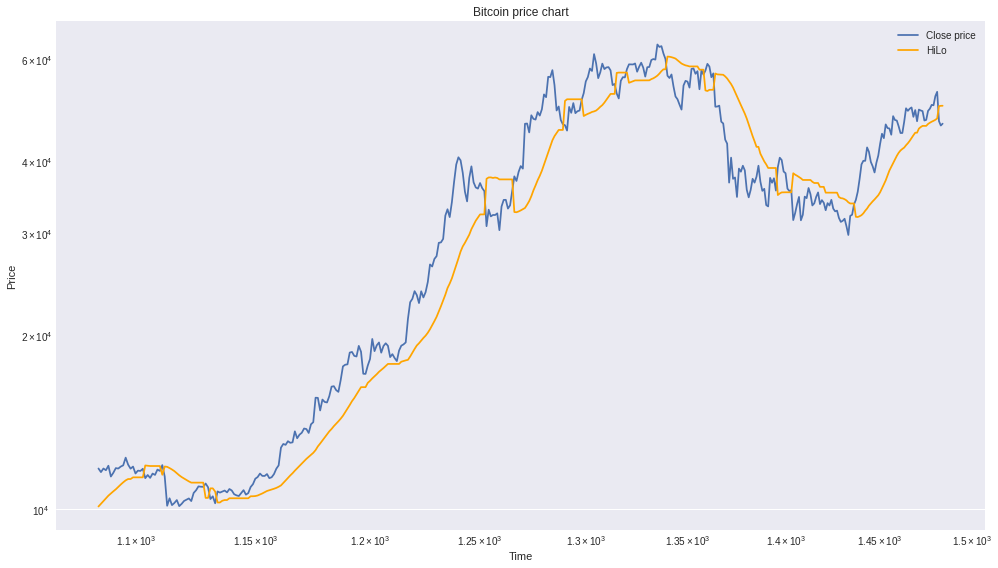

In [30]:
plt.style.use('seaborn')
plt.figure(figsize=(14,8))


plt.plot(df['close'].tail(400), label="Close price")
plt.plot(df['hilo'].tail(400), label="HiLo", color='Orange')

# plt.plot_date(df['date'], y, linestyle='solid')
# plt.gcf().autofmt_xdate()

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Bitcoin price chart")
plt.legend()
plt.tight_layout()
plt.show()

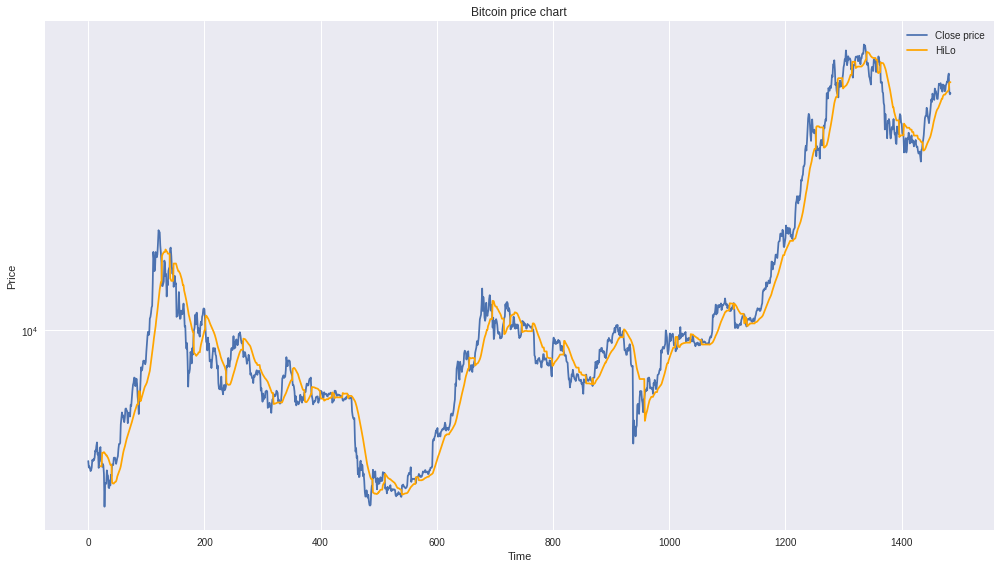

In [33]:
plt.style.use('seaborn')
plt.figure(figsize=(14,8))


plt.plot(df['close'], label="Close price")
plt.plot(df['hilo'], label="HiLo", color='Orange')

# plt.plot_date(df['date'], y, linestyle='solid')
# plt.gcf().autofmt_xdate()

# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Bitcoin price chart")
plt.legend()
plt.tight_layout()
plt.show()

## MACD

In [22]:
pta.macd(close=df['close'], fast=None, slow=None, signal=None, offset=None).tail(5)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
8433,-141.667252,85.050964,-226.718216
8434,-248.586381,-17.494533,-231.091849
8435,-380.280214,-119.350692,-260.929522
8436,-447.763869,-149.467478,-298.296391
8437,-595.824011,-238.022096,-357.801915


In [23]:
df['macdh'] = pta.macd(close=df['close'], fast=29, slow=40, signal=9, offset=None)['MACDh_29_40_9']
df['buy2'] = (df['macdh'] > 0)
df.tail(15)

,date,open,high,low,close,volume,hilo,buy1,macdh,buy2
8423,2021-06-23 20:00:00,32882.50,33785.26,32749.01,33678.07,12525.748531,32039.097857,True,26.788073,True
8424,2021-06-24 00:00:00,33675.07,33879.99,32339.82,32589.20,14734.386878,32039.097857,True,20.669005,True
8425,2021-06-24 04:00:00,32589.20,33280.55,32286.57,32853.74,13051.055908,32039.097857,True,20.955376,True
8426,2021-06-24 08:00:00,32853.74,33930.23,32820.61,33850.77,13506.337429,32252.901429,True,36.251527,True
8427,2021-06-24 12:00:00,33850.78,34583.58,33756.04,33886.52,18730.794267,32344.118571,True,48.046779,True
8428,2021-06-24 16:00:00,33888.81,35298.00,33751.00,34857.73,18670.724202,32532.618571,True,70.414372,True
8429,2021-06-24 20:00:00,34854.63,34999.09,34512.00,34663.09,7932.505576,32940.261429,True,83.002927,True
8430,2021-06-25 00:00:00,34663.08,35500.00,34251.00,35052.07,14634.093456,33128.190000,True,96.627754,True
8431,2021-06-25 04:00:00,35057.70,35100.00,33961.48,34283.82,12494.567347,33128.190000,True,94.025827,True
8432,2021-06-25 08:00:00,34281.37,34480.00,33234.37,33311.96,19245.555409,33128.190000,True,76.989502,True


MACD cijfers kloppen

## Supertrend en signalen

In [24]:
# Supertrend opnemen in dataframe
df['st'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], length=7, multiplier=2.0)['SUPERTd_7_2.0']
# df.drop(['supertrend'], axis = 1)
df.tail(5)

,date,open,high,low,close,volume,hilo,buy1,macdh,buy2,st
8433,2021-06-25 12:00:00,33311.96,33600.77,32351.00,32607.07,26868.158019,34411.831429,False,53.897818,True,1
8434,2021-06-25 16:00:00,32607.07,32910.64,31500.00,32220.74,28395.534991,34298.305714,False,31.606785,True,-1
8435,2021-06-25 20:00:00,32222.91,32369.00,31275.00,31584.45,14423.221134,34118.877143,False,6.845371,True,-1
8436,2021-06-26 00:00:00,31576.09,32268.91,31300.00,31977.59,12066.947988,33999.001429,False,-4.324972,False,-1
8437,2021-06-26 04:00:00,31979.71,32730.00,30573.77,30720.37,21059.902932,33923.625714,False,-29.174721,False,-1


In [1]:
# Supertrend signaal
df['buy3'] = (df['st'].shift(+1) != df['st'])&(df['st'] == 1)

# Toon alleen de buy == True signalen
df[['date','buy3']][df['buy3']==True].tail(15)

NameError: name 'df' is not defined

In [26]:
df.tail(25)

,date,open,high,low,close,volume,hilo,buy1,macdh,buy2,st,buy3
8413,2021-06-22 04:00:00,33018.21,33109.81,32479.00,32648.98,10838.814384,34526.106429,False,-115.902953,False,-1,False
8414,2021-06-22 08:00:00,32647.96,32658.63,31112.00,31243.41,31110.251480,34301.722857,False,-124.323287,False,-1,False
8415,2021-06-22 12:00:00,31236.53,31980.00,28805.00,31708.08,86060.162400,34020.151429,False,-119.364420,False,-1,False
8416,2021-06-22 16:00:00,31707.56,33298.78,31620.00,32404.06,37371.545784,33849.072857,False,-101.639795,False,-1,False
8417,2021-06-22 20:00:00,32404.06,32987.00,32150.00,32509.56,14917.591475,33849.072857,False,-83.675241,False,-1,False
8418,2021-06-23 00:00:00,32509.56,34444.00,31683.00,33966.43,32702.644564,32010.962857,True,-46.599024,False,1,True
8419,2021-06-23 04:00:00,33969.69,34392.10,33574.11,33982.26,18440.425426,31881.970714,True,-17.466728,False,1,False
8420,2021-06-23 08:00:00,33982.26,34500.00,33650.21,33911.39,18341.765169,31816.498571,True,4.064729,True,1,False
8421,2021-06-23 12:00:00,33911.40,34881.00,33400.30,33490.14,28265.873145,31897.520000,True,14.642365,True,1,False
8422,2021-06-23 16:00:00,33490.14,33947.17,32870.99,32879.97,16689.643728,31897.520000,True,14.462476,True,1,False


In [28]:
df['entry'] = (df['buy1'] == True) & (df['buy2'] == True) & (df['buy3'] == True)

# Toon alleen de Entry == True signalen
df[['date','entry']][df['entry']==True].tail(25)

,date,entry
6225,2020-06-22 12:00:00,True
6279,2020-07-01 12:00:00,True
6307,2020-07-06 04:00:00,True
6389,2020-07-19 20:00:00,True
6602,2020-08-24 08:00:00,True
6636,2020-08-30 00:00:00,True
6720,2020-09-13 00:00:00,True
6729,2020-09-14 12:00:00,True
6855,2020-10-05 12:00:00,True
6873,2020-10-08 12:00:00,True


ALs macd 1 dag later op groen springt, dan ook instappen:
Dus True entry moet 1 dag lag kunnen hebben waardoor er 2 dagen true zijn.

``df['entry'] = (df['buy1'] == True) & (df['buy2'] == True) & ((df['buy3'] == True) | (df['buy3'].shift(1) == True))''

In [31]:
df['entry'] = (df['buy1'] == True) & (df['buy2'] == True) & ((df['buy3'] == True) | (df['buy3'].shift(1) == True))

# Toon alleen de Entry == True signalen
df[['date','entry']][df['entry']==True].tail(55)

,date,entry
6068,2020-05-27 08:00:00,True
6069,2020-05-27 12:00:00,True
6225,2020-06-22 12:00:00,True
6226,2020-06-22 16:00:00,True
6279,2020-07-01 12:00:00,True
6280,2020-07-01 16:00:00,True
6307,2020-07-06 04:00:00,True
6308,2020-07-06 08:00:00,True
6389,2020-07-19 20:00:00,True
6390,2020-07-20 00:00:00,True
